# Homework 1
Connor Blake

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd
import sklearn
import rdkit
import seaborn as sns

## Problem 1

### a)

In [2]:
sol_df = pd.read_csv("curated-solubility-dataset.csv")
print(sol_df.columns)

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


### b)

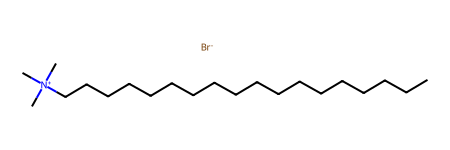

In [3]:
mol = rdkit.Chem.MolFromInchi(sol_df['InChI'][0])
mol

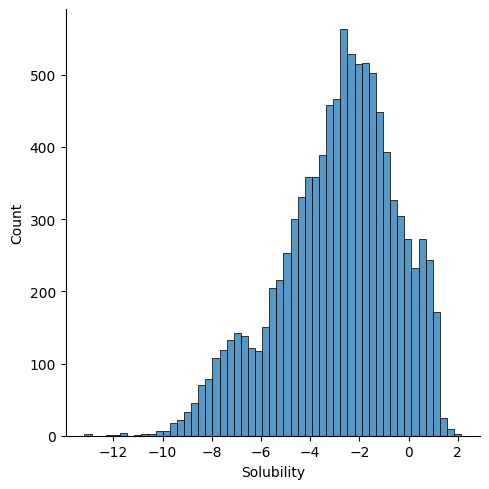

In [4]:
sns.displot(sol_df['Solubility'])
plt.show()

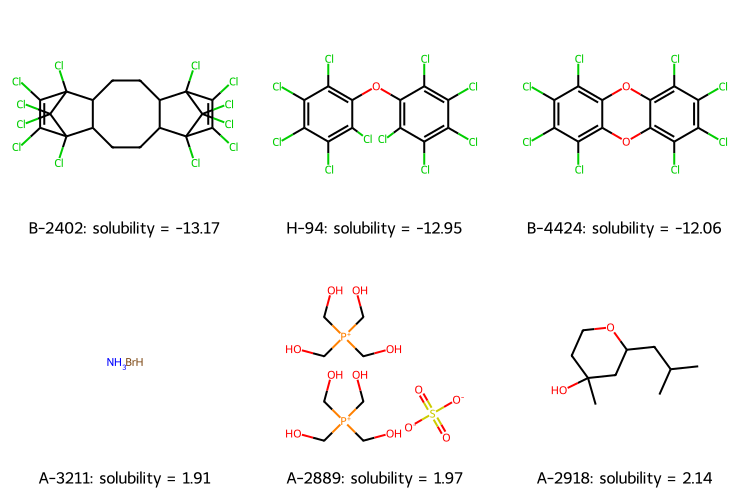

In [5]:
# get 3 lowest and 3 highest solubilities
soldata_sorted = sol_df.sort_values("Solubility")
extremes = pd.concat([soldata_sorted[:3], soldata_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [
    f"{x.ID}: solubility = {x.Solubility:.2f}" for x in extremes.itertuples()
]

# now plot them on a grid
extreme_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in extremes.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    extreme_mols, molsPerRow=3, subImgSize=(250, 250), legends=legend_text
)

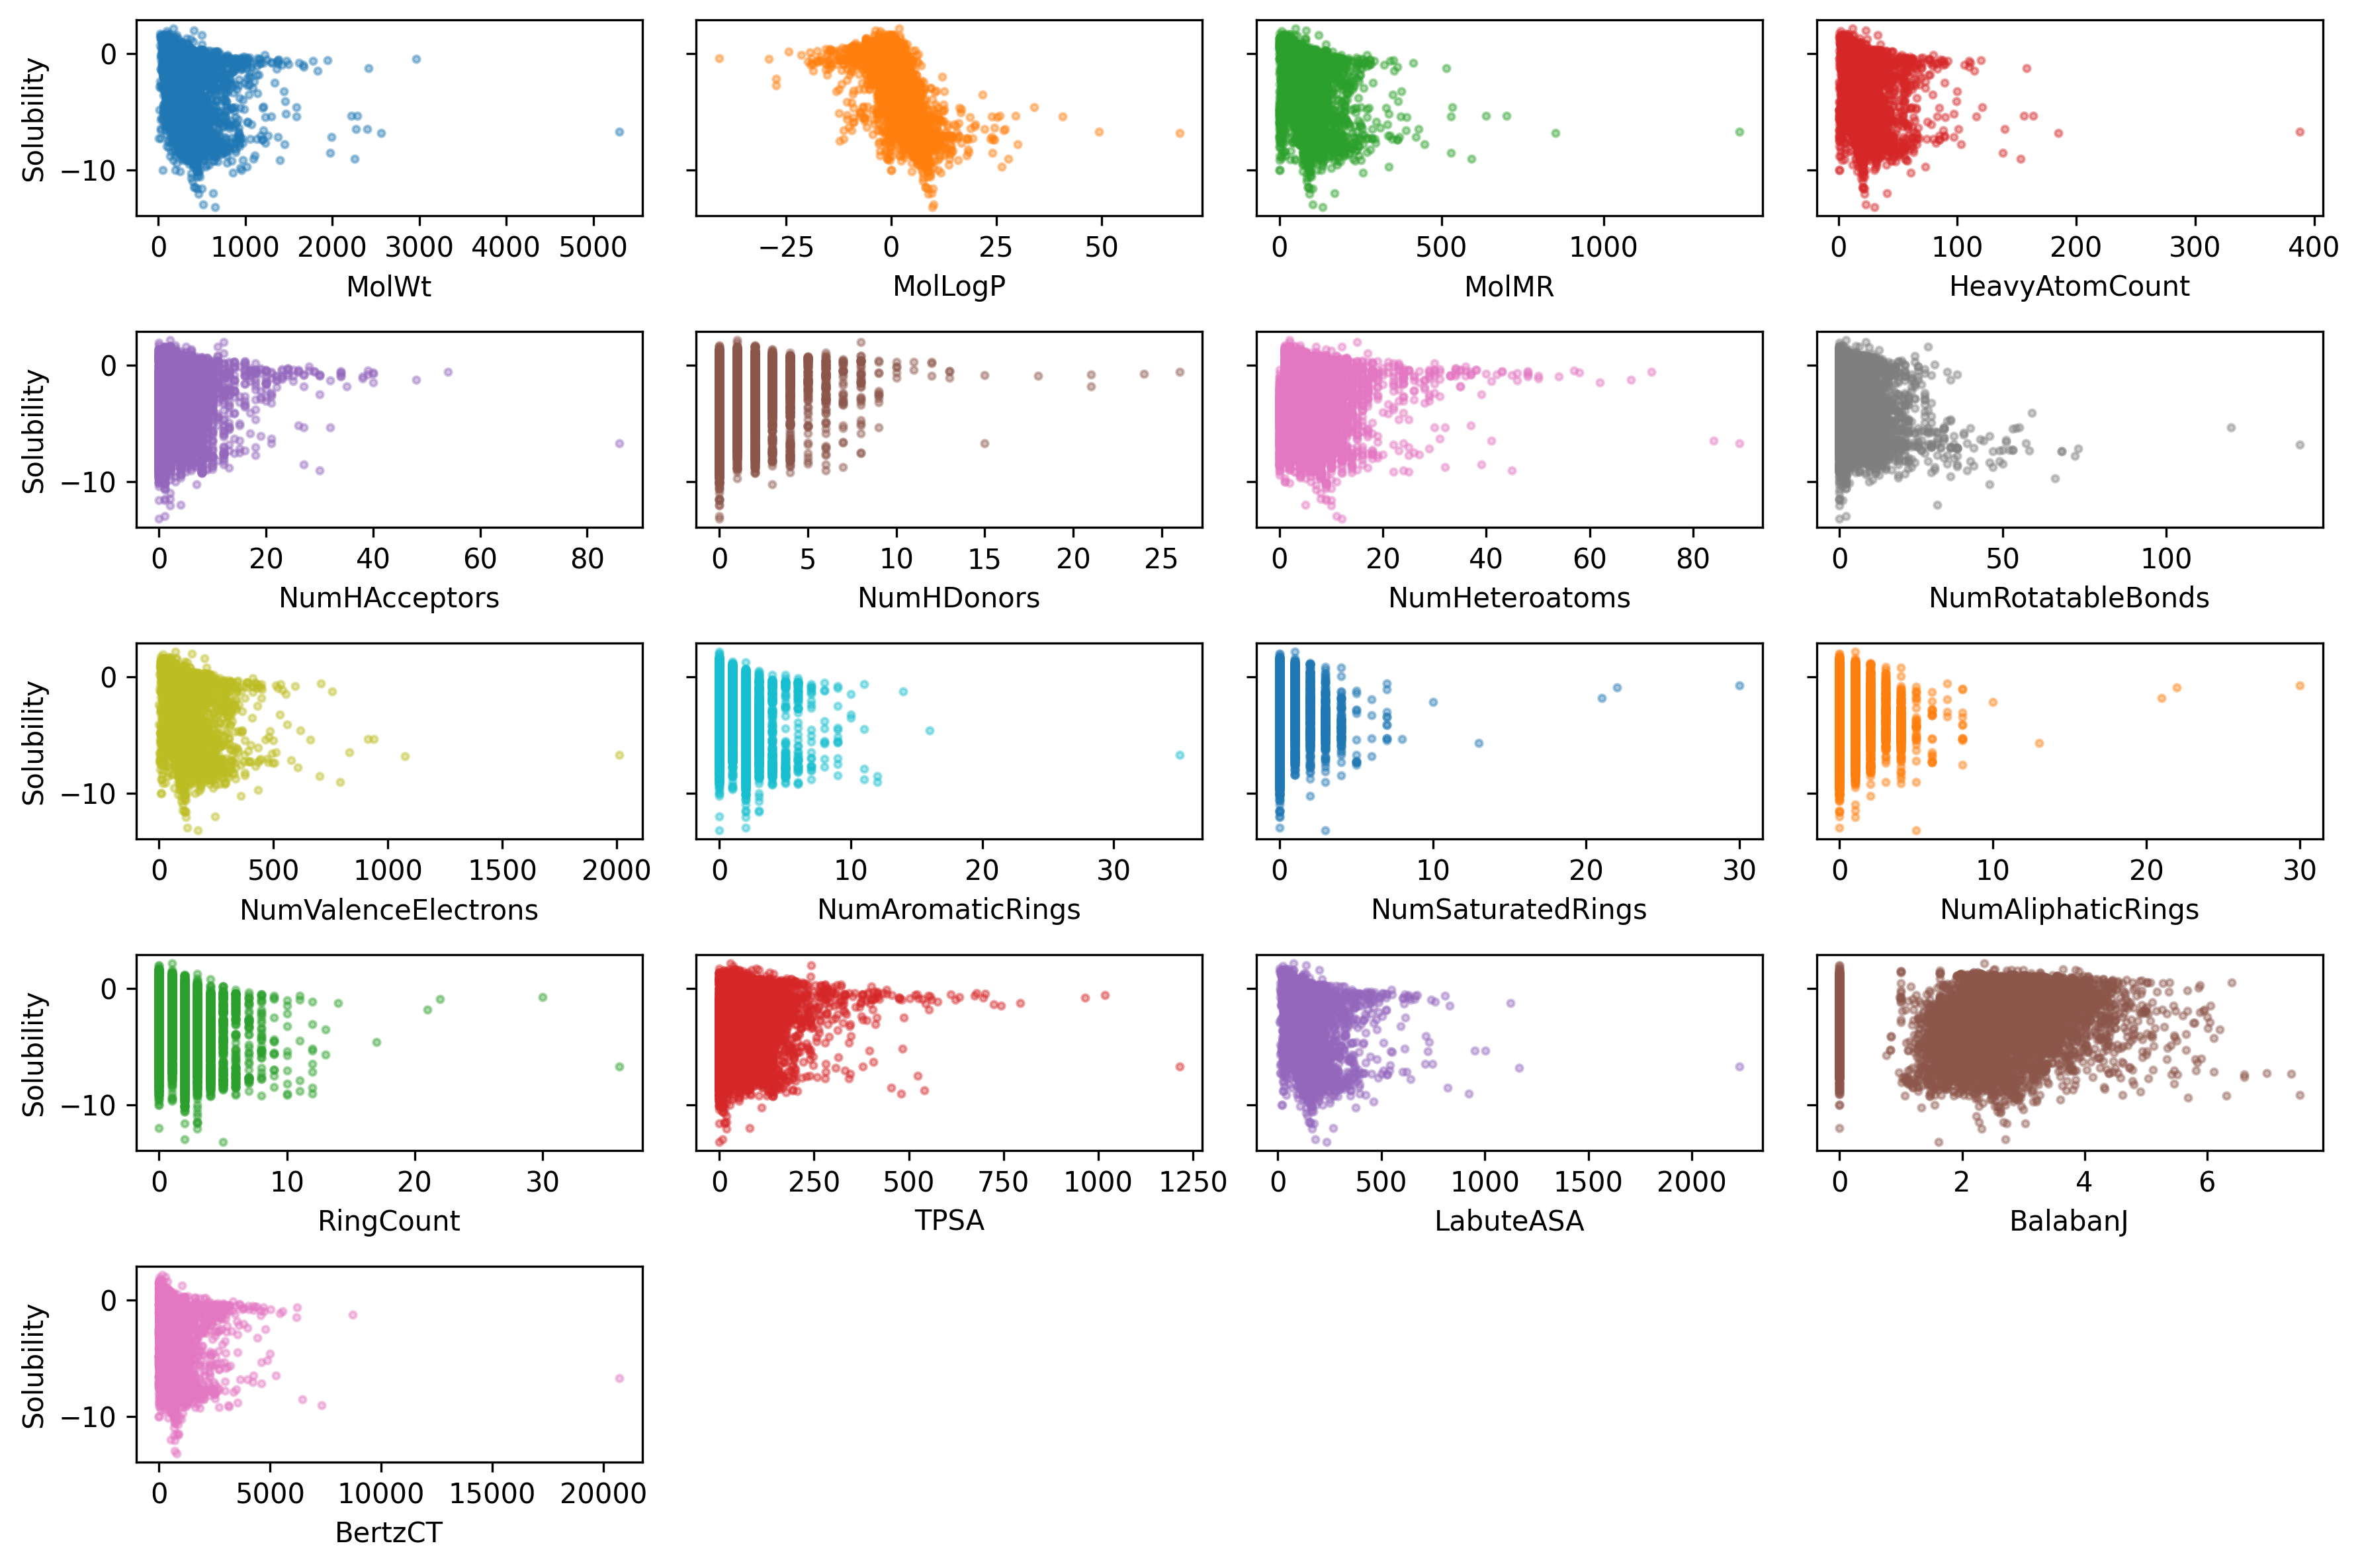

In [6]:
features_start_at = list(sol_df.columns).index("MolWt")
feature_names = sol_df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        sol_df[n], sol_df.Solubility, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

In [7]:
@jax.jit
def loss(y, y_pred):
    return jnp.mean((y-y_pred)**2)

@jax.jit
def linear_model(x,w,b):
    return jnp.dot(x,w) + b

In [8]:
X = sol_df.loc[:, feature_names].values
Y = sol_df.Solubility.values
feature_dim = X.shape[1]
W_ls = jnp.linalg.inv(X.T@X)@(X.T)@Y # exact least squares

In [9]:
print(X.shape,Y.shape,W_ls.shape)

(9982, 17) (9982,) (17,)


In [10]:
y_pred_least_squares = X@W_ls
print(f"Least Squares Loss: {loss(Y,y_pred_least_squares):.3f}")

Least Squares Loss: 894.192


In [11]:
jkey = jax.random.PRNGKey(seed=1)
W = jax.random.normal(jkey, shape=(feature_dim,))
b = 0.0
y_pred_init = linear_model(X,W,b)
print(f"Initial Loss: {loss(y_pred=y_pred_init,y=Y):.3f}")

Initial Loss: 3049262.500


In [12]:
# compute gradients
def loss_wrapper(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss(y, labels)


loss_grad = jax.grad(loss_wrapper, (0, 1))

# test it out
loss_grad(W, b, (X,Y))

(Array([-1.0566712e+06, -6.7454404e+03, -2.6333500e+05, -7.0201008e+04,
        -1.4914125e+04, -3.7587854e+03, -2.1377963e+04, -1.5376594e+04,
        -3.6943481e+05, -5.2474111e+03, -9.3971899e+02, -1.7016848e+03,
        -6.9490952e+03, -2.5272359e+05, -4.3806009e+05, -4.7533628e+03,
        -2.5049482e+06], dtype=float32),
 Array(-2388.4155, dtype=float32, weak_type=True))

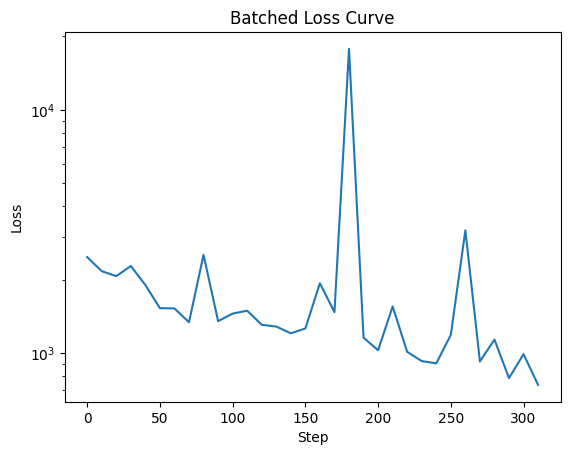

In [13]:
W = jax.random.normal(jkey, shape=(feature_dim,))
b = 0.0

loss_progress = []
eta = 1e-6
batch_size = 32
N = len(X)  # number of data points
data = (X,Y)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(X) // batch_size * batch_size

# the -1 means that numpy will compute
# what that dimension should be
batched_features = X[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = Y[:new_N].reshape((-1, batch_size))
# to make it random, we'll iterate over the batches randomly
indices = np.arange(new_N // batch_size)
np.random.shuffle(indices)
for i in indices:
    # choose a random set of
    # indices to slice our data
    grad = loss_grad(W, b, (batched_features[i], batched_labels[i]))
    W = W - eta * grad[0]
    b = b - eta * grad[1]
    # we still compute loss on whole dataset, but not every step
    if i % 10 == 0:
        loss_progress.append(loss_wrapper(W, b, data))

plt.plot(np.arange(len(loss_progress)) * 10, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Batched Loss Curve")
plt.show()

In [14]:
sol_df[feature_names].corrwith(sol_df['Solubility']).sort_values(ascending=True)

MolLogP               -0.608580
MolMR                 -0.424452
MolWt                 -0.368032
HeavyAtomCount        -0.352748
LabuteASA             -0.349497
NumValenceElectrons   -0.346369
NumAromaticRings      -0.343257
RingCount             -0.329599
BertzCT               -0.289403
NumRotatableBonds     -0.222040
NumAliphaticRings     -0.087706
NumHeteroatoms        -0.040432
NumSaturatedRings     -0.037794
BalabanJ               0.037329
NumHAcceptors          0.040020
TPSA                   0.111662
NumHDonors             0.193066
dtype: float64

MolLogP, MolMR, MolWT seem to have the most predictive power for solubility, so they should be important for the analysis.

In [15]:
feature_names

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

In [16]:
corr = sol_df[feature_names.tolist() + ['Solubility']].corr()
corr


,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Solubility
MolWt,1.000000,0.274489,0.918897,0.950358,0.728544,0.300740,0.778160,0.607132,0.945888,0.570508,0.166785,0.256686,0.618948,0.653639,0.972633,-0.350478,0.860903,-0.368032
MolLogP,0.274489,1.000000,0.489295,0.333832,-0.249365,-0.266122,-0.238849,0.400844,0.357257,0.249597,-0.008381,0.018135,0.210392,-0.377232,0.280342,0.199313,0.197622,-0.608580
MolMR,0.918897,0.489295,1.000000,0.974646,0.617344,0.274044,0.576984,0.696115,0.973741,0.613457,0.179147,0.269113,0.661120,0.496881,0.956373,-0.269328,0.852327,-0.424452
HeavyAtomCount,0.950358,0.333832,0.974646,1.000000,0.737311,0.339465,0.710718,0.656378,0.992939,0.623851,0.203594,0.296704,0.687093,0.638169,0.983198,-0.322215,0.901773,-0.352748
NumHAcceptors,0.728544,-0.249365,0.617344,0.737311,1.000000,0.492136,0.889812,0.395080,0.719298,0.438130,0.165544,0.222708,0.491738,0.900391,0.736286,-0.296685,0.741841,0.040020
NumHDonors,0.300740,-0.266122,0.274044,0.339465,0.492136,1.000000,0.452983,0.180429,0.346488,0.134581,0.207908,0.206509,0.239624,0.630250,0.301494,-0.110805,0.302379,0.193066
NumHeteroatoms,0.778160,-0.238849,0.576984,0.710718,0.889812,0.452983,1.000000,0.330042,0.692642,0.432433,0.086571,0.144714,0.437176,0.886101,0.740770,-0.304440,0.734350,-0.040432
NumRotatableBonds,0.607132,0.400844,0.696115,0.656378,0.395080,0.180429,0.330042,1.000000,0.711553,0.093157,-0.035145,-0.049750,0.042274,0.310484,0.650056,-0.057034,0.357666,-0.222040
NumValenceElectrons,0.945888,0.357257,0.973741,0.992939,0.719298,0.346488,0.692642,0.711553,1.000000,0.545148,0.223450,0.301787,0.627680,0.623296,0.973901,-0.294061,0.851719,-0.346369
NumAromaticRings,0.570508,0.249597,0.613457,0.623851,0.438130,0.134581,0.432433,0.093157,0.545148,1.000000,-0.129662,-0.044564,0.767743,0.355337,0.601068,-0.280060,0.824108,-0.343257


Sorted by magnitude of correlation:

In [17]:
p = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool)).stack().reset_index()
p.columns = ['Feature 1', 'Feature 2', 'corr']
print(p.sort_values(by='corr', key=abs, ascending=False).head(20))

               Feature 1            Feature 2      corr
52        HeavyAtomCount  NumValenceElectrons  0.992939
58        HeavyAtomCount            LabuteASA  0.983198
33                 MolMR       HeavyAtomCount  0.974646
113  NumValenceElectrons            LabuteASA  0.973901
38                 MolMR  NumValenceElectrons  0.973741
13                 MolWt            LabuteASA  0.972633
44                 MolMR            LabuteASA  0.956373
2                  MolWt       HeavyAtomCount  0.950358
7                  MolWt  NumValenceElectrons  0.945888
1                  MolWt                MolMR  0.918897
125    NumSaturatedRings    NumAliphaticRings  0.903483
60        HeavyAtomCount              BertzCT  0.901773
70         NumHAcceptors                 TPSA  0.900391
63         NumHAcceptors       NumHeteroatoms  0.889812
148            LabuteASA              BertzCT  0.889010
93        NumHeteroatoms                 TPSA  0.886101
15                 MolWt              BertzCT  0

### c)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
X = sol_df[feature_names]
y = sol_df["Solubility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
print(X_train.shape, X_test.shape)

(7985, 17) (1997, 17)


It is useful to normalize the features because we have a constant learning rate for all variables, but the natural units of the data for the features varies considerably which means that they are then implicitly weighted differently in the model. Normalization removes this bias between features.

### d)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression().fit(X_train, y_train)

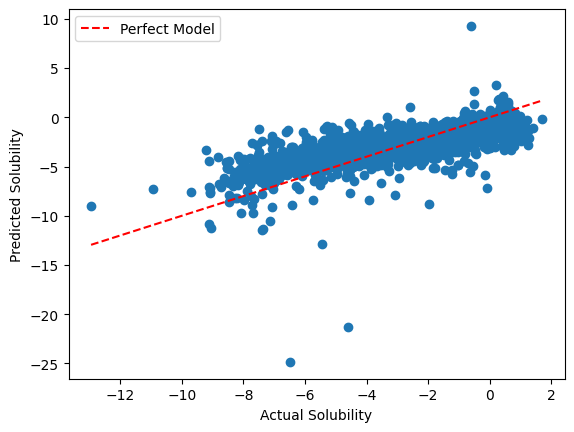

Largest coefficients by magnitude
HeavyAtomCount         6.595637
NumValenceElectrons    4.809274
BertzCT                2.603915
MolLogP                1.536503
MolMR                  1.140097
MolWt                  0.758080
LabuteASA              0.742702
NumHeteroatoms         0.739342
NumHAcceptors          0.535803
NumAromaticRings       0.493917
dtype: float64

RMSE=1.654


In [22]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--',label="Perfect Model")
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.legend()
plt.show()
feat_imp = pd.Series(model.coef_, index=feature_names).abs().sort_values(ascending=False)
print("Largest coefficients by magnitude")
print(feat_imp.head(10))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print()
print(f"RMSE={rmse:.3f}")


We see that heavy atom count is the most important feature in this linear model followed by NumValence electrons and BertzCT.

### e)

In [23]:
from sklearn.linear_model import Lasso

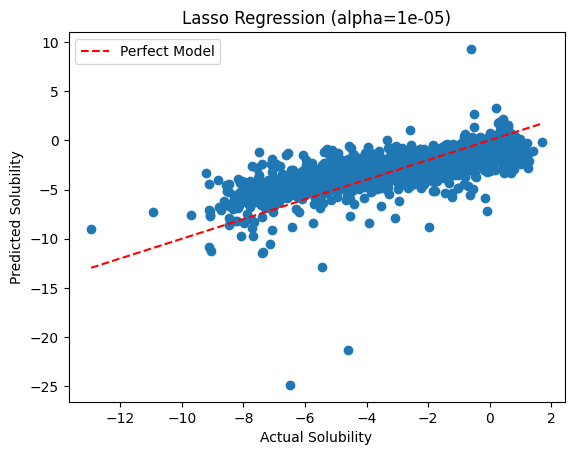

Alpha: 1e-05
HeavyAtomCount         6.582323
NumValenceElectrons    4.799118
BertzCT                2.602291
MolLogP                1.536278
MolMR                  1.139442
NumAromaticRings       0.833034
MolWt                  0.757472
LabuteASA              0.744051
NumHeteroatoms         0.739228
NumHAcceptors          0.535647
dtype: float64

RMSE=1.654


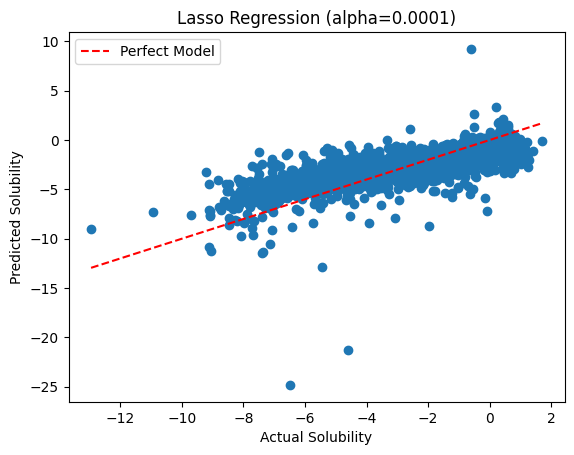

Alpha: 0.0001
HeavyAtomCount         6.462560
NumValenceElectrons    4.707756
BertzCT                2.587682
MolLogP                1.534247
MolMR                  1.133551
LabuteASA              0.756179
MolWt                  0.751999
NumHeteroatoms         0.738207
NumAromaticRings       0.679218
NumHAcceptors          0.534242
dtype: float64

RMSE=1.654


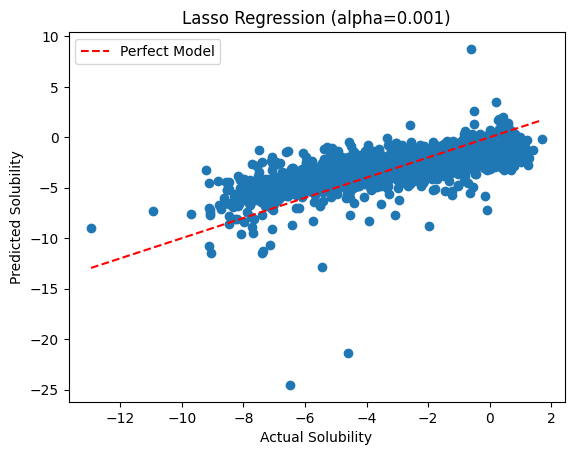

Alpha: 0.001
HeavyAtomCount         5.272697
NumValenceElectrons    3.801597
BertzCT                2.440461
MolLogP                1.514130
MolMR                  1.073430
LabuteASA              0.874936
NumHeteroatoms         0.728459
MolWt                  0.697673
RingCount              0.618773
NumHAcceptors          0.520511
dtype: float64

RMSE=1.651


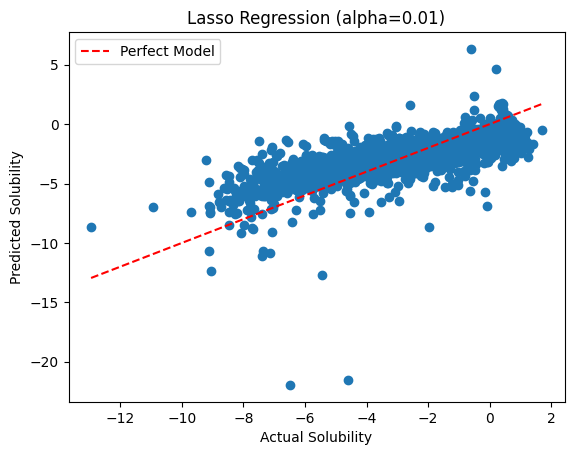

Alpha: 0.01
BertzCT              1.568705
MolLogP              1.285246
LabuteASA            0.850084
NumHeteroatoms       0.719139
RingCount            0.667955
MolWt                0.564923
NumHAcceptors        0.480807
NumAromaticRings     0.478091
NumRotatableBonds    0.278439
NumHDonors           0.258281
dtype: float64

RMSE=1.644


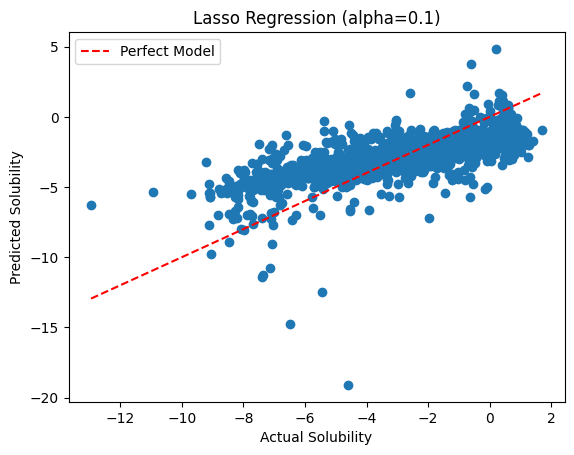

Alpha: 0.1
MolLogP                1.055773
MolWt                  0.447411
NumHDonors             0.219567
RingCount              0.170240
NumAromaticRings       0.141961
NumHAcceptors          0.113076
NumRotatableBonds      0.021378
BalabanJ               0.003582
HeavyAtomCount         0.000000
NumValenceElectrons    0.000000
dtype: float64

RMSE=1.685


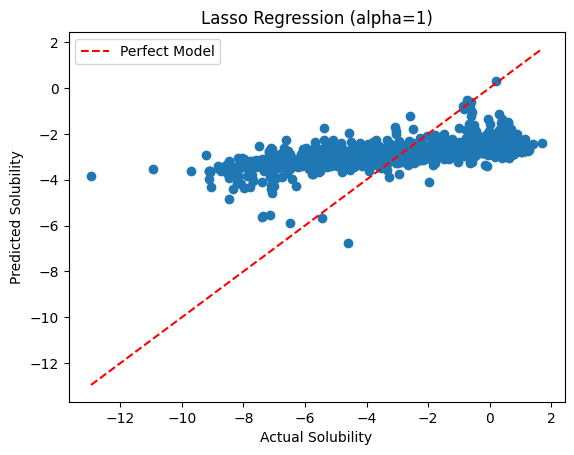

Alpha: 1
MolLogP                0.42809
MolWt                  0.00000
MolMR                  0.00000
HeavyAtomCount         0.00000
NumHAcceptors          0.00000
NumHDonors             0.00000
NumHeteroatoms         0.00000
NumRotatableBonds      0.00000
NumValenceElectrons    0.00000
NumAromaticRings       0.00000
dtype: float64

RMSE=2.088


In [24]:
for a in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    model = Lasso(alpha=a, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--',label="Perfect Model")
    plt.xlabel('Actual Solubility')
    plt.ylabel('Predicted Solubility')
    plt.title(f'Lasso Regression (alpha={a})')
    plt.legend()
    plt.show()
    print(f"Alpha: {a}")
    print(pd.Series(model.coef_, index=feature_names).abs().sort_values(ascending=False).head(10))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print()
    print(f"RMSE={rmse:.3f}")


The most import features are HeavyAtomCount for low values of regularization, BertzCT for medium levels of regularization (lowest RMSE), and MolLogP for highest values of regularization. 

## Problem 2

### a)

In [25]:
url_white = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
url_red = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white = pd.read_csv(url_white, sep=";")
red = pd.read_csv(url_red, sep=";")
white["wine_type"] = "white"
red["wine_type"] = "red"
df = pd.concat([white, red], ignore_index=True)
df.to_csv("wine_quality.csv", index=False)
print(df["wine_type"].value_counts())

wine_type
white    4898
red      1599
Name: count, dtype: int64


If one class dominates the other, the classifier might default to picking the dominant class and be a poor predictor of the smaller classes. This imbalance of ~3:1 is not too bad and should not significantly adversely affect the analysis such that rebalancing techniques are required.

### b)

For classification, we want to look at features which can distinguish the two groups most clearly, so correlations between features in a category may not be as important as in regression. First I'll just look at intergroup relative means and standard deviations.

In [26]:
wine_features = [c for c in white.columns if c != "wine_type"]
wm = white[wine_features].mean()
rm = red[wine_features].mean()
ws = white[wine_features].std()
rs = red[wine_features].std()
result = pd.DataFrame({"white_mean": wm, "red_mean": rm, "rel_mean": (wm - rm)/rm, "white_std": ws, "red_std": rs, "rel_std": (ws - rs)/rs,"rel_ratio": ((wm - rm)/rm)/((ws-rs)/rs)})
result.sort_values(by="rel_mean",inplace=True,ascending=False)
result

,white_mean,red_mean,rel_mean,white_std,red_std,rel_std,rel_ratio
total sulfur dioxide,138.360657,46.467792,1.977560,42.498065,32.895324,0.291918,6.774368
residual sugar,6.391415,2.538806,1.517489,5.072058,1.409928,2.597388,0.584237
free sulfur dioxide,35.308085,15.874922,1.224142,17.007137,10.460157,0.625897,1.955821
citric acid,0.334192,0.270976,0.233290,0.121020,0.194801,-0.378752,-0.615944
quality,5.877909,5.636023,0.042918,0.885639,0.807569,0.096672,0.443956
alcohol,10.514267,10.422983,0.008758,1.230621,1.065668,0.154788,0.056580
density,0.994027,0.996747,-0.002728,0.002991,0.001887,0.584726,-0.004666
pH,3.188267,3.311113,-0.037101,0.151001,0.154386,-0.021931,1.691720
fixed acidity,6.854788,8.319637,-0.176071,0.843868,1.741096,-0.515324,0.341671
sulphates,0.489847,0.658149,-0.255720,0.114126,0.169507,-0.326719,0.782692


We see that total sulfur dioxide, residual sugar, and free sulfur dioxide have significantly different relative means differing by more than 100% which will be helpful for prediction. Chlorides have a very small std in red but much larger in white, and they have different means.

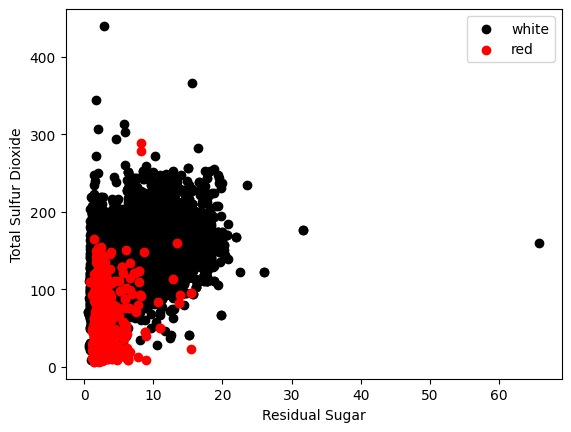

In [27]:
plt.scatter(white["residual sugar"], white["total sulfur dioxide"], color="black", label="white")
plt.scatter(red["residual sugar"], red["total sulfur dioxide"], color="red", label="red")
plt.xlabel("Residual Sugar")
plt.ylabel("Total Sulfur Dioxide")
plt.legend()
plt.show()


Despite very different means, we see that these two variables alone are not sufficient for classification as there is significant overlap in the region of the red wines.

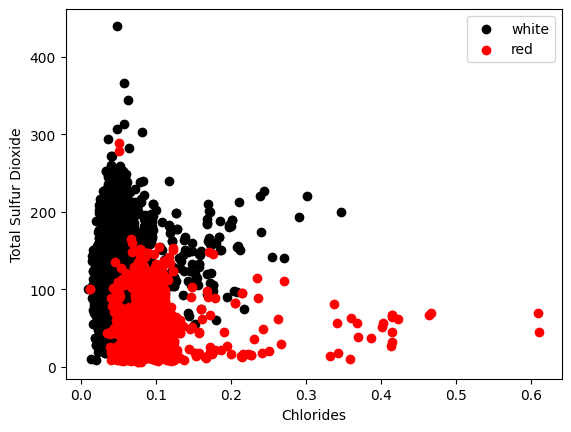

In [28]:
plt.scatter(white["chlorides"], white["total sulfur dioxide"], color="black", label="white")
plt.scatter(red["chlorides"], red["total sulfur dioxide"], color="red", label="red")
plt.xlabel("Chlorides")
plt.ylabel("Total Sulfur Dioxide")
plt.legend()
plt.show()


Examining Top Correlation Features

In [29]:
red_corr = red[wine_features].corr()
rp = red_corr.where(np.triu(np.ones(red_corr.shape), 1).astype(bool)).stack().reset_index()
rp.columns = ['Feature 1', 'Feature 2', 'corr']
print(rp.sort_values(by='corr', key=abs, ascending=False).head(20))

              Feature 1             Feature 2      corr
7         fixed acidity                    pH -0.682978
1         fixed acidity           citric acid  0.671703
6         fixed acidity               density  0.668047
45  free sulfur dioxide  total sulfur dioxide  0.667666
11     volatile acidity           citric acid -0.552496
26          citric acid                    pH -0.541904
58              density               alcohol -0.496180
65              alcohol               quality  0.476166
20     volatile acidity               quality -0.390558
42            chlorides             sulphates  0.371260
25          citric acid               density  0.364947
33       residual sugar               density  0.355283
56              density                    pH -0.341699
27          citric acid             sulphates  0.312770
41            chlorides                    pH -0.265026
18     volatile acidity             sulphates -0.260987
0         fixed acidity      volatile acidity -0

In [30]:
white_corr = white[wine_features].corr()
wp = white_corr.where(np.triu(np.ones(white_corr.shape), 1).astype(bool)).stack().reset_index()
wp.columns = ['Feature 1', 'Feature 2', 'corr']
print(wp.sort_values(by='corr', key=abs, ascending=False).head(20))

               Feature 1             Feature 2      corr
33        residual sugar               density  0.838966
58               density               alcohol -0.780138
45   free sulfur dioxide  total sulfur dioxide  0.615501
51  total sulfur dioxide               density  0.529881
36        residual sugar               alcohol -0.450631
54  total sulfur dioxide               alcohol -0.448892
65               alcohol               quality  0.435575
7          fixed acidity                    pH -0.425858
32        residual sugar  total sulfur dioxide  0.401439
43             chlorides               alcohol -0.360189
59               density               quality -0.307123
31        residual sugar   free sulfur dioxide  0.299098
46   free sulfur dioxide               density  0.294210
1          fixed acidity           citric acid  0.289181
6          fixed acidity               density  0.265331
40             chlorides               density  0.257211
49   free sulfur dioxide       

From this we see that in white wine, density and residual sugar are highly correlated in a way that they are not in red wine. This could potentially be a useful feature.

### c)

In [31]:
X = df.drop(columns=["wine_type"])
y = df["wine_type"].map({"white": 0, "red": 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### d)

In [32]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import confusion_matrix
perc = Perceptron(random_state=42).fit(X_train_scaled, y_train)
logreg = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
perc_cm = np.array(confusion_matrix(y_test, perc.predict(X_test_scaled)))
logreg_cm = np.array(confusion_matrix(y_test, logreg.predict(X_test_scaled)))
print(f"Perceptron: Accuracy={np.trace(perc_cm)/np.sum(perc_cm):.3f}")
print(perc_cm)
print(f"Logistic Regression: Accuracy={np.trace(logreg_cm)/np.sum(logreg_cm):.3f}")
print(logreg_cm)

Perceptron: Accuracy=0.978
[[966  20]
 [  8 306]]
Logistic Regression: Accuracy=0.990
[[981   5]
 [  8 306]]


The logistic regression has fewer misclassifications of white wines as red. Both have the exact same number of red wine correct predictions.

### e)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
results = []
for depth in [3, 5, 10]:
    print()
    for n in [10, 50, 100]:
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n, random_state=42)
        rf.fit(X_train_scaled, y_train)
        acc = accuracy_score(y_test, rf.predict(X_test_scaled))
        results.append((depth, n, acc))
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        print(f"Depth: {depth}, Trees: {n}, Accuracy: {acc:.4f}")
        print(f"\tTop 4 Features (Lazy): {importances.index[0]} ({importances.iloc[0]:.3f}), {importances.index[1]} ({importances.iloc[1]:.3f}), {importances.index[2]} ({importances.iloc[2]:.3f}), {importances.index[3]} ({importances.iloc[3]:.3f})")
        feature_permutation = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10,random_state=41,n_jobs=2)
        pimportances = pd.Series(feature_permutation.importances_mean, index=X.columns).sort_values(ascending=False)
        print(f"\tTop 4 Features (full): {pimportances.index[0]} ({pimportances.iloc[0]:.3f}), {pimportances.index[1]} ({pimportances.iloc[1]:.3f}), {pimportances.index[2]} ({pimportances.iloc[2]:.3f}), {pimportances.index[3]} ({pimportances.iloc[3]:.3f})")



Depth: 3, Trees: 10, Accuracy: 0.9785
	Top 4 Features (Lazy): chlorides (0.457), total sulfur dioxide (0.221), volatile acidity (0.156), fixed acidity (0.055)


/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


	Top 4 Features (full): chlorides (0.089), total sulfur dioxide (0.080), volatile acidity (0.026), sulphates (0.003)
Depth: 3, Trees: 50, Accuracy: 0.9823
	Top 4 Features (Lazy): chlorides (0.283), total sulfur dioxide (0.256), volatile acidity (0.221), sulphates (0.048)
	Top 4 Features (full): total sulfur dioxide (0.058), chlorides (0.041), volatile acidity (0.024), residual sugar (0.005)
Depth: 3, Trees: 100, Accuracy: 0.9854
	Top 4 Features (Lazy): total sulfur dioxide (0.293), chlorides (0.278), volatile acidity (0.168), free sulfur dioxide (0.063)
	Top 4 Features (full): chlorides (0.054), total sulfur dioxide (0.054), volatile acidity (0.019), density (0.005)

Depth: 5, Trees: 10, Accuracy: 0.9892
	Top 4 Features (Lazy): chlorides (0.429), total sulfur dioxide (0.198), volatile acidity (0.132), fixed acidity (0.063)
	Top 4 Features (full): chlorides (0.078), total sulfur dioxide (0.066), volatile acidity (0.015), density (0.005)
Depth: 5, Trees: 50, Accuracy: 0.9938
	Top 4 Featu

For the largest numbers of trees, total sulfur dioxide is the most important feature, but for the smaller forests chlorides is. The overall accuracy is more closely tied to the depth than the number of trees as a (10,10) (depth,trees) matches (5,100) model 5x as large, but all are fairly high. The higher depth models further cut the misclassification rate in half from the logistic regression classifier. For models with fewer trees, the importance of the top feature (chloride) is much larger than for models with more trees (fewer trees = more interpretable), though this relationship is not monotonic. Going from 50 to 100 trees does not significantly improve the accuracy (and actually decreases it in the depth=5 case which indicates overfitting). Only ~3 features matter in all models.

chlorides               0.457032
total sulfur dioxide    0.221426
volatile acidity        0.156421
fixed acidity           0.055173
sulphates               0.049782
pH                      0.019418
free sulfur dioxide     0.014995
residual sugar          0.008991
density                 0.006263
citric acid             0.006121
alcohol                 0.004261
quality                 0.000119
dtype: float64


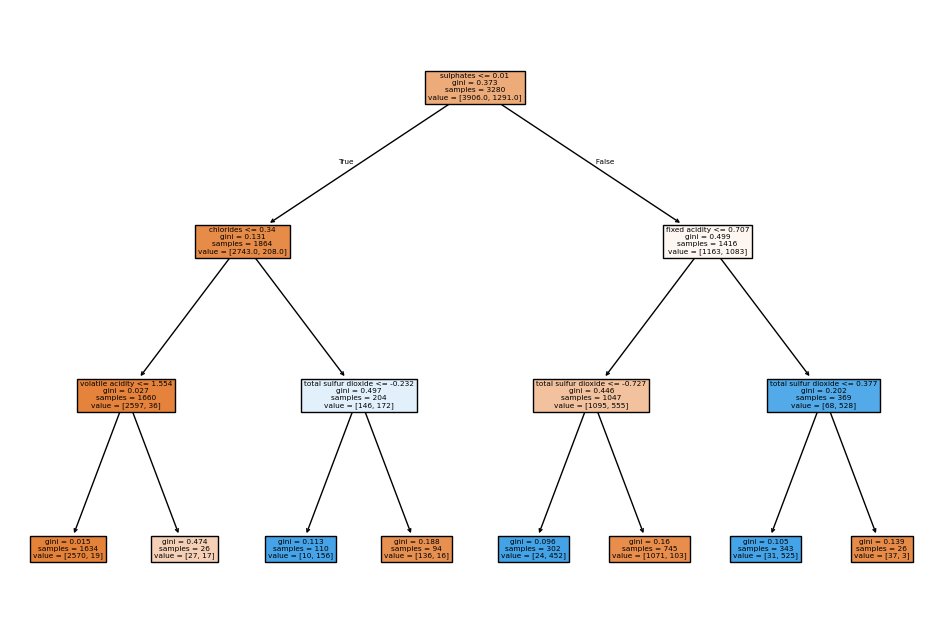

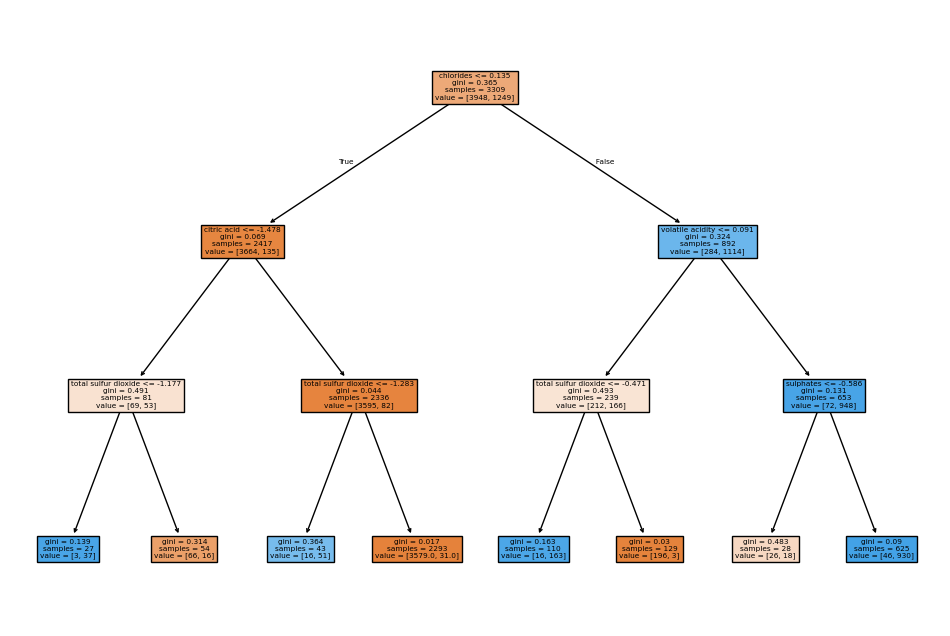

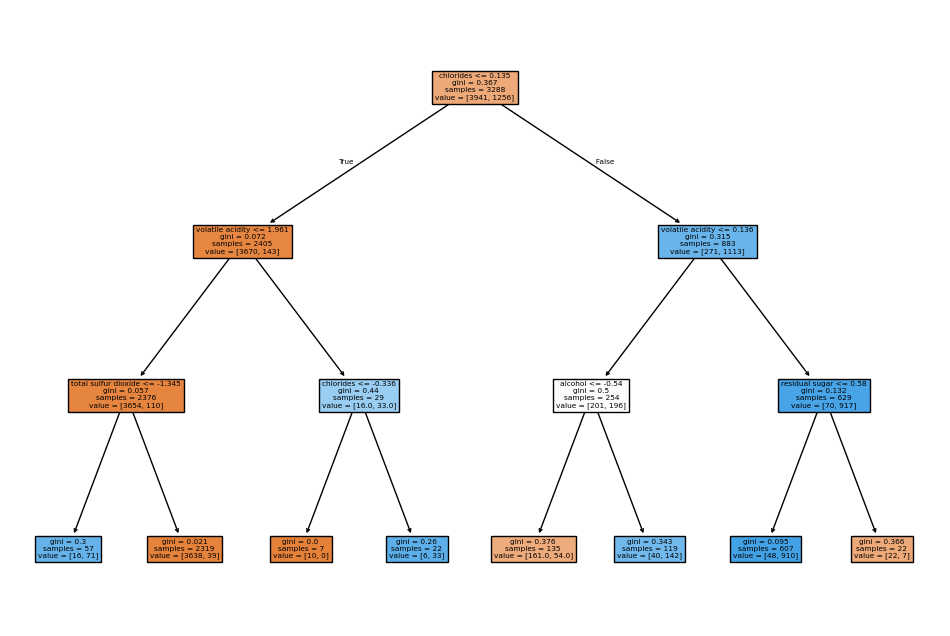

In [34]:
rf_shallow = RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)
rf_shallow.fit(X_train_scaled, y_train)
print(pd.Series(rf_shallow.feature_importances_, index=X.columns).sort_values(ascending=False))
for i in range(3):
    plt.figure(figsize=(12,8))
    plot_tree(rf_shallow.estimators_[i], feature_names=X.columns, filled=True)
    plt.show()